# HUK-Coding Challenge


__Contents__

1. Data Analysis
2. Modelbuilding
3. Evaluation

In [62]:
import pandas as pd
import os
from huk_challenge.config import ProjectPaths

In [63]:

train = pd.read_csv(os.path.join(ProjectPaths.data, "training.csv"), header=None)
vali = pd.read_csv(os.path.join(ProjectPaths.data, "validation.csv"), header=None)
vali.columns = ["id","topic", "sentiment", "text"]
train.columns = ["id", "topic", "sentiment", "text"]
vali.head()

,id,topic,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## 1. Explorative Analysis

This __analysis explores the training dataset__. 

__Validation dataset will be treated as it is an unknown dataset__, since we will just evaluate the performance on it. We will only preprocess the individual strings we receive from the validation dataset.


In [64]:
print(f"Training examples: {train.shape[0]}")
print(f"Validation examples: {vali.shape[0]}")

Training examples: 74682
Validation examples: 1000


<Axes: xlabel='sentiment', ylabel='count'>

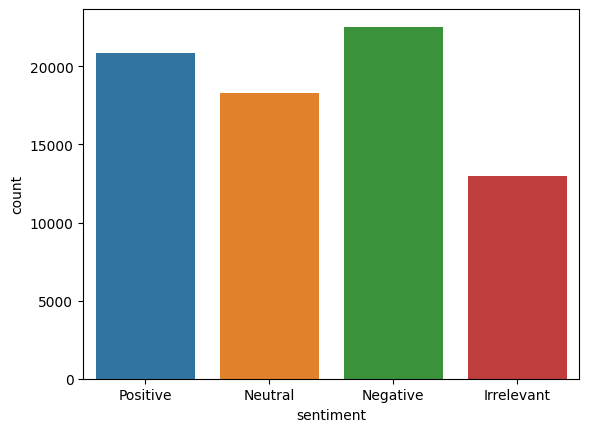

In [65]:
import seaborn as sns

sns.countplot(train, x="sentiment")

In [66]:
irrelevant = train.loc[train["sentiment"] == "Irrelevant", "text"]
irrelevant.iloc[22]

'I\'m in fact this entire @CBP video. @DHS_Wolf deceptively cut these parts of our report :.. The [UNK] before saying " this is ripping into Arizona and... the rest side of the borderlands in two. ". [UNK] admittedly surveilling us on public road after violent clashes began with Indigenous American activists over protesting wall.'

Looking through a few of the examples marked as _irrelevant_ they do seem irrelevant for the sentiment. Therefore these examples will be excluded from training.
However a robust Sentiment Classification model should be able to detect, when some examples are out of distribution -meaning they are not part of the distribution the model was trained on. There is variety of literature ob that including some previous publications I worked on. For now entries marked as _irrelevant_ in the training set will simply be excluded.

Publication Example: [Bounding open space risk with decoupling autoencoders in open set recognition](https://link.springer.com/article/10.1007/s41060-022-00342-z)

Entities, seem to be marked wth "@" symbols.


### Filter empty entries

In [67]:
filtered_train = train.loc[train["sentiment"] != "Irrelevant",:]
print(f"Training examples: {filtered_train.shape[0]}")

Training examples: 61692


In [68]:
filtered_train = filtered_train.loc[~filtered_train["text"].isna(),:]
print(f"Training examples: {filtered_train.shape[0]}")

Training examples: 61121


In [69]:
filtered_train.loc[filtered_train["text"] == "", :]

,id,topic,sentiment,text


### Filter Meaningless Entries

In [70]:
filtered_train.loc[filtered_train["text"].apply(lambda x: len(x) == 3), :]

,id,topic,sentiment,text
11,2402,Borderlands,Positive,was
53,2409,Borderlands,Neutral,all
191,2432,Borderlands,Positive,why
455,2476,Borderlands,Positive,one
467,2478,Borderlands,Positive,can
...,...,...,...,...
74369,9144,Nvidia,Negative,the
74387,9147,Nvidia,Positive,and
74393,9148,Nvidia,Neutral,the
74507,9171,Nvidia,Neutral,You


* Texts with minor lengths do not seem to have relevant content
* Sentiments are not in line with used words

--> Exclude them from the training set

I checked for more lengths and decided to exclude everything below, a meaningful length of 3, as words like "Wow" already indicate a positive sentiment. However there are still words which are not meaningful.

In [71]:
filtered_train = filtered_train.loc[filtered_train["text"].apply(lambda x: len(x) > 2), :]

### Stopword Removal (Entries)

* To get rid of more meaningless words, one option is to exclude stopwords. I used nltks list of __english stopwords__ and filtered the dataset for it.

In [72]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


def remove_stops(tweet):
    tweet = tweet.lower()
    stops = set(stopwords.words('english'))
    val = True
    if tweet in stops:
        val = False
    return val

filtered_train = filtered_train.loc[filtered_train["text"].apply(remove_stops), :]
print(f"Training examples: {filtered_train.shape[0]}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elysias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training examples: 59944


Lets compare that, with our previous useless words:

We see that mostly positive sentiments expressed by "Wow" seem to remain.
However here we may run into a data leackage problem, as "Wow" is then trained for __multiple times__, which might not change much and the word may be given to much weight. We therefore need to make sure to need __unique entries__.

In [73]:
filtered_train.loc[filtered_train["text"].apply(lambda x: len(x) == 3), :]

,id,topic,sentiment,text
455,2476,Borderlands,Positive,one
2094,2767,Borderlands,Positive,Wow
2095,2767,Borderlands,Positive,Wow
2096,2767,Borderlands,Positive,Wow
2097,2767,Borderlands,Positive,Wow
...,...,...,...,...
72426,8808,Nvidia,Positive,Wow
72427,8808,Nvidia,Positive,Wow
72428,8808,Nvidia,Positive,Wow
72429,8808,Nvidia,Positive,Wow


Looks way better now!

### Drop Duplicates

* Wow occures multiple times
* we want to avoid bias through data leackage -> therefore we drop all duplicates


In [74]:
filtered_train = filtered_train.drop_duplicates(subset="text")
print(f"Training examples: {filtered_train.shape[0]}")

Training examples: 57207


### Check Language

* I would check for the language at that point
* Execution time on my local machine is too long - therefore I skipped this part

-> It is also reasonable to check language before performing inference.

In [76]:
# from langdetect import detect
# from langdetect import LangDetectException


# def detect_lang(tweet):
#     try:
#         language = detect(tweet.lower())
#     except LangDetectException:
#         language = tweet
#     return language

# languages = filtered_train["text"].apply(lambda x: detect_lang(x))
# set(languages)

### ID Field

* The provided ID field could either indicate __users__ or __subtopics__
* Identical IDs always talk about a similar topic and subtopic
* Same ID tweets are always very similar, but not identical

--> Playing with them around in the sentiment classification might give variying results, in our current approach we will include all statements from similar IDs

In [90]:
filtered_train.loc[filtered_train["id"] == 2475, ["sentiment", "text"]].to_dict()

{'sentiment': {444: 'Positive',
  445: 'Positive',
  446: 'Positive',
  447: 'Positive',
  448: 'Positive',
  449: 'Positive'},
 'text': {444: 'Just officiated a gay wedding in Borderlands 3, feeling powerful rn.',
  445: 'I just celebrated a gay wedding in Borderlands 3 and felt powerful.',
  446: 'Just played a gay wedding in Borderlands 3, feeling powerful.',
  447: 'Just officiated a gay wedding in Borderlands 3, the powerful rn.',
  448: 'Just officiated a gay fan wedding in WWE Borderlands Episode 3, feeling powerful rn.',
  449: 'once officiated a gay wedding in Borderlands 3, as powerful rn.'}}

### Class balance after filtering

<Axes: xlabel='sentiment', ylabel='count'>

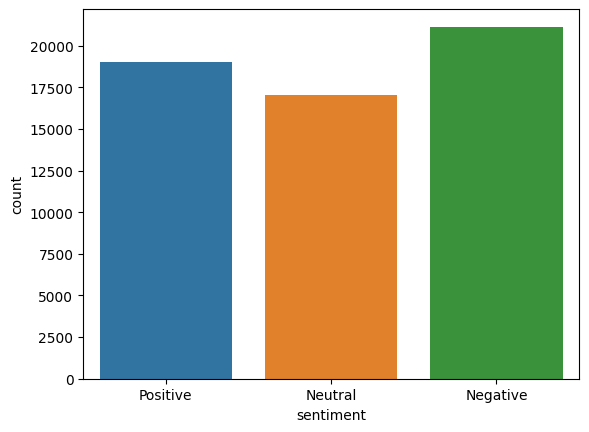

In [91]:
sns.countplot(filtered_train, x="sentiment")

### Further Options for Analysis:

* Plot Word Embeddings, with the Langauge Model we are going to use and get an impression for the difficulty
* Identify Edges of the given Training classes --> Which instances are very similar to others?

This can also be performed in an ex post analysis, when investigating the probability predictions of the model.

## 2. Modelbuilding